Loading 15 daily files …


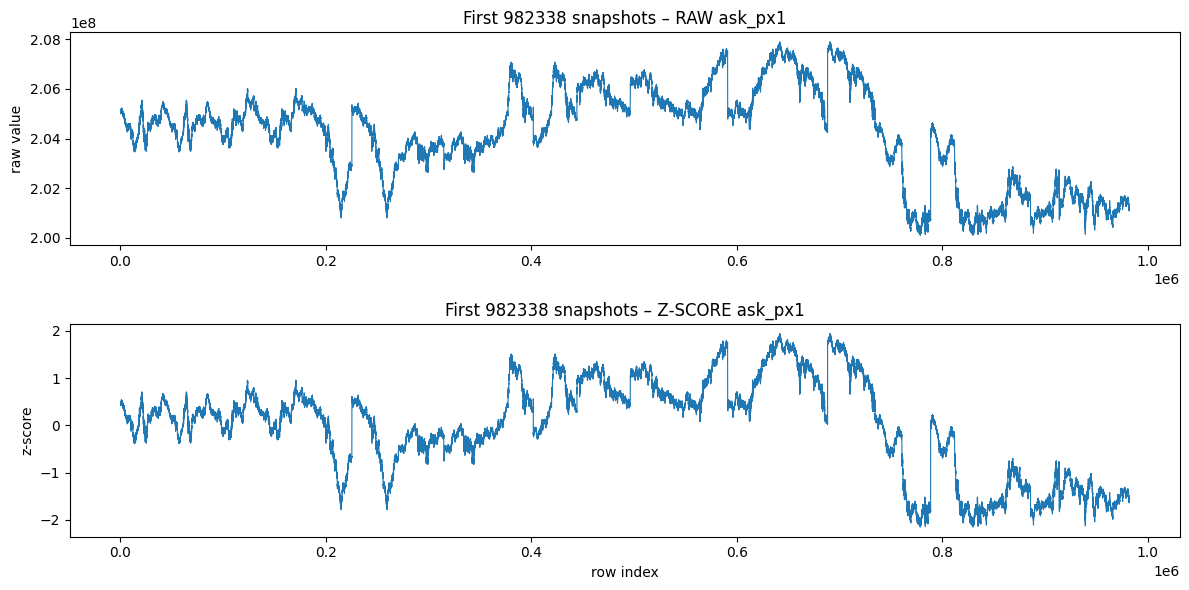

In [6]:
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ---------------------------------------------------------------
#  helper: inter‑leaved column layout (ask_px0, ask_sz0, …)
# ---------------------------------------------------------------
BLOCK_COLS = (
    ["timestamp"]
    + [f"ask_px{i}" for i in range(10)]
    + [f"bid_px{i}" for i in range(10)]
    + [f"ask_sz{i}" for i in range(10)]
    + [f"bid_sz{i}" for i in range(10)]
)
IL_COLS = [
    f"{side}_{typ}{lvl}"
    for lvl in range(10)
    for side, typ in (("ask", "px"), ("ask", "sz"), ("bid", "px"), ("bid", "sz"))
]

# ---------------------------------------------------------------
#  z‑score routine (your original, returns *new* DF)
# ---------------------------------------------------------------

def z_score_orderbook(data_in: pd.DataFrame,
                      mean_size=None, mean_prices=None,
                      std_size=None,  std_prices=None):
    """Return a **copy** with z‑scored values; never mutates input."""
    data = data_in.copy()

    if (mean_size is None) or (std_size is None):
        mean_size = data.iloc[:, 1::2].stack().mean()
        std_size  = data.iloc[:, 1::2].stack().std()
    if (mean_prices is None) or (std_prices is None):
        mean_prices = data.iloc[:, 0::2].stack().mean()
        std_prices  = data.iloc[:, 0::2].stack().std()

    price_cols = data.columns[0::2]
    size_cols  = data.columns[1::2]

    for col in size_cols:
        data[col] = (data[col].astype("float64") - mean_size) / std_size
    for col in price_cols:
        data[col] = (data[col].astype("float64") - mean_prices) / std_prices

    if data.isnull().values.any():
        raise ValueError("data contains null value")
    return data

# ---------------------------------------------------------------
#  loader: daily CSV (block order) → IL DataFrame
# ---------------------------------------------------------------

def load_one_csv(fp: Path):
    df = pd.read_csv(fp, names=BLOCK_COLS)
    return df[["timestamp"] + IL_COLS]

# ---------------------------------------------------------------
#  main routine
# ---------------------------------------------------------------

def main(raw_dir: str | Path,
         pattern: str = "NQ_*.csv",
         col: str = "ask_px1",
         n_plot: int = 1000000):
    raw_dir = Path(raw_dir)
    files = sorted(raw_dir.glob(pattern))
    if not files:
        print(f"No files match '{pattern}' in {raw_dir.resolve()}")
        return

    print(f"Loading {len(files)} daily files …")
    df_all = pd.concat([load_one_csv(f) for f in files], ignore_index=True)

    # --- split timestamp vs features -----------------------------------
    ts         = df_all.pop("timestamp")  # not needed for plot but kept
    feat_raw   = df_all.copy()             # preserve ORIGINAL values
    feat_z     = z_score_orderbook(df_all) # safe: returns *new* DF

    # --- plotting ------------------------------------------------------
    n = min(n_plot, len(feat_raw))
    x = np.arange(n)

    plt.figure(figsize=(12, 6))

    plt.subplot(2, 1, 1)
    plt.plot(x, feat_raw[col].values[:n], lw=0.8)
    plt.title(f"First {n} snapshots – RAW {col}")
    plt.ylabel("raw value")

    plt.subplot(2, 1, 2)
    plt.plot(x, feat_z[col].values[:n], lw=0.8)
    plt.title(f"First {n} snapshots – Z‑SCORE {col}")
    plt.ylabel("z‑score")
    plt.xlabel("row index")

    plt.tight_layout()
    plt.show()

# ---------------------------------------------------------------
#  DEMO CALL — uses your daily‑CSV folder
# ---------------------------------------------------------------
raw_dir = Path(r"C:\Users\jiruszde\OneDrive\Main\1.Projects\My\Trading\Jupyter\2025-tlob\data\NQ\day_csv")

if raw_dir.exists():
    main(raw_dir)
else:
    print("⚠️  Folder not found – check path and rerun this cell.")


Total 1-s snapshots in file(s): 982,338
Plotting first 1,800 snapshots


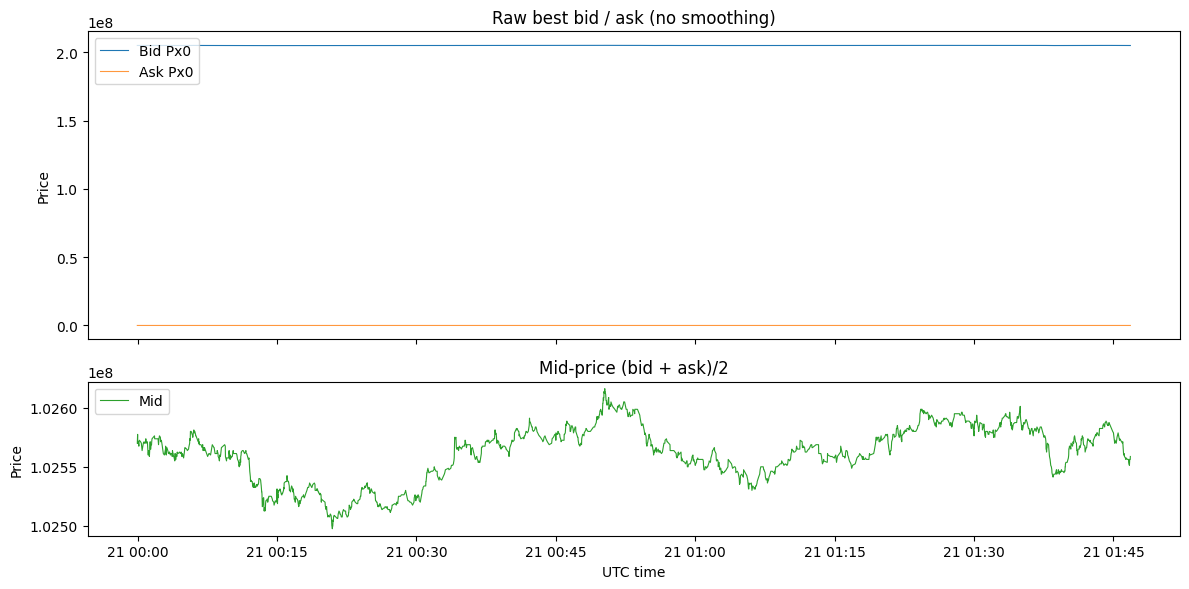

In [5]:
#!/usr/bin/env python3
"""
plot_mid_price.py
────────────────────────────────────────────────────────────────────────────
Two-panel sanity-check:

A. Raw best bid / ask after 1-second resampling (no smoothing)
B. Mid-price series used for Δ-tick label logic
"""

from __future__ import annotations
from pathlib import Path

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# ───────── USER SETTINGS ──────────────────────────────────────────────────
CSV_FILES   = [r"C:\Users\jiruszde\OneDrive\Main\1.Projects\My\Trading\Jupyter\2025-tlob\data\raw-sierra\dom-datatick.csv"]
RESAMPLE_TO = "1s"        # lower-case ‘s’ = no future deprecation warning
MAX_POINTS  = 1800      # how many snapshots to plot
# ──────────────────────────────────────────────────────────────────────────

COLS = (
    ["timestamp"]
    + [f"bid_px{i}" for i in range(10)]
    + [f"bid_sz{i}" for i in range(10)]
    + [f"ask_px{i}" for i in range(10)]
    + [f"ask_sz{i}" for i in range(10)]
)

# -------------------------------------------------------------------------
def _read(path: Path) -> pd.DataFrame:
    df = pd.read_csv(path, names=COLS, header=None)

    # unix-epoch-ms *or* ISO-8601 → pandas UTC
    if pd.api.types.is_numeric_dtype(df["timestamp"]):
        df["timestamp"] = pd.to_datetime(df["timestamp"], unit="ms",
                                         utc=True, errors="coerce")
    else:
        df["timestamp"] = pd.to_datetime(df["timestamp"], utc=True,
                                         errors="coerce", format="ISO8601")
    df = df.dropna(subset=["timestamp"])

    return df
# -------------------------------------------------------------------------

frames = [_read(Path(p)) for p in CSV_FILES]
df     = pd.concat(frames, ignore_index=True)

# first N points
n_plot = min(MAX_POINTS, len(df))
ts     = df["timestamp"].iloc[:n_plot]

# raw best bid / ask
bid0 = df["bid_px0"].to_numpy(float)[:n_plot]
ask0 = df["ask_px0"].to_numpy(float)[:n_plot]
mid  = (bid0 + ask0) / 2.0

print(f"Total 1-s snapshots in file(s): {len(df):,}")
print(f"Plotting first {n_plot:,} snapshots")

# ────────── PLOT ──────────────────────────────────────────────────────────
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 6), sharex=True,
                               gridspec_kw={"height_ratios": [2, 1]})

# Panel A – raw best bid / ask
ax1.plot(ts, bid0,  label="Bid Px0",  linewidth=0.8)
ax1.plot(ts, ask0,  label="Ask Px0",  linewidth=0.8, alpha=0.8)
ax1.set_title("Raw best bid / ask (no smoothing)")
ax1.set_ylabel("Price")
ax1.legend(loc="upper left")

# Panel B – mid-price
ax2.plot(ts, mid, color="tab:green", linewidth=0.8, label="Mid")
ax2.set_title("Mid-price (bid + ask)/2")
ax2.set_xlabel("UTC time")
ax2.set_ylabel("Price")
ax2.legend(loc="upper left")

fig.tight_layout()
plt.show()


Daily CSVs already exist – skipping re‑split.
Alpha: 0.00010680409103563201
Number of labels: (array([0, 1, 2]), array([  1784, 838543,   2046]))
Percentage of labels: [0.00211783 0.99545332 0.00242885]
Alpha: 0.00039345191442995207
Number of labels: (array([0, 1, 2]), array([   152, 186876,    145]))
Percentage of labels: [8.12082939e-04 9.98413233e-01 7.74684383e-04]
Alpha: 0.0004586931747379925
Number of labels: (array([0, 1, 2]), array([   476, 526863,    576]))
Percentage of labels: [9.01660305e-04 9.98007255e-01 1.09108474e-03]
Alpha: 0.0002242900513839257
Number of labels: (array([0, 1, 2]), array([  2292, 837497,   2574]))
Percentage of labels: [0.00272092 0.99422339 0.00305569]
Alpha: 0.0008355524818667902
Number of labels: (array([0, 1, 2]), array([   115, 186887,    161]))
Percentage of labels: [6.14437683e-04 9.98525350e-01 8.60212756e-04]
Alpha: 0.0009344646418432569
Number of labels: (array([0, 1, 2]), array([   543, 526679,    683]))
Percentage of labels: [0.00102859 0.9